# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [946]:
from random import random, choices, choice, randint
import numpy as np
import lab9_lib
from dataclasses import dataclass
from copy import copy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [947]:
GENOME_LENGHT = 1000
TOURNAMENT_SIZE = 20
POPULATION_SIZE = 100
MUTATION_PROBABILITY = 0.2
PARENTS_SIZE = 2
OFFSPRING_SIZE = 20
PROBLEM_SIZE_SMALL = 1
PROBLEM_SIZE_BIG = 10
GENERATION_SIZE = 3000
@dataclass
class Individual:
    fitness: float
    genotype: list[int]

In [948]:

def create_game_and_population(dimension):
    fitness = lab9_lib.make_problem(dimension)
    population = [Individual(
        genotype =  choices([0, 1], k=GENOME_LENGHT),
        fitness = 0,
        ) for _ in range(POPULATION_SIZE)]
    for a in population:
        a.fitness = fitness(a.genotype)
    return population,fitness

# (1+λ)

In [949]:
def parent_selection(population):
    index_of_tournamet = [randint(0, POPULATION_SIZE-1) for _ in range(TOURNAMENT_SIZE)]
    tournament = [population[i] for i in index_of_tournamet]
    tournament.sort(key=lambda i: i.fitness, reverse=True)
    return tournament[0]

def parent_selection2(population):
    pool = [choice(population) for _ in range(PARENTS_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion


def xover(parent1:Individual ,parent2: Individual):
    mutation_prob_rate = [random() for _ in range(GENOME_LENGHT)]
    parents = [parent1,parent2]
    best = max(parents, key=lambda i: i.fitness)
    other = min(parents, key=lambda i: i.fitness)
    newInd = Individual(fitness=0, genotype=[p1 if r < .5 else p2 for p1,p2,r in zip(best.genotype,other.genotype, mutation_prob_rate)])
    return newInd

def mutateRandom(parent: Individual):
    offspring = copy(parent)
    gene_index = randint(0,GENOME_LENGHT-1)
    offspring.genotype[gene_index] = choice((0,1))
    return offspring

def mutateFlip(parent: Individual):
    offspring = copy(parent)
    gene_index = randint(0,GENOME_LENGHT-1)
    offspring.genotype[gene_index] = 1-offspring.genotype[gene_index]
    return offspring


def mutate(parent: Individual):
    offspring = copy(parent)
    gene_index = randint(0,GENOME_LENGHT-1)
    offspring.genotype[gene_index] = 1
                
    return offspring

def one_cut_xover(parent1:Individual ,parent2: Individual):
    cut_point=randint(0,GENOME_LENGHT-1)
    offspring=Individual(fitness=None,genotype=parent1.genotype[:cut_point]+parent2.genotype[cut_point:])
    return offspring

def ILM_DHC(generation):
    return generation/GENERATION_SIZE, 1-(generation/GENERATION_SIZE)
def DHM_ILC(generation):
    return 1-(generation/GENERATION_SIZE), (generation/GENERATION_SIZE)

# mu + lamdba
def mu_plus_lambda(population, fitness, mutation_function, MR, CR, STATIC_RATE=False ,ILM=True):
    generation = 0
    fitness_history = []
    mr_history =[]
    cr_history = []
    
    for _ in tqdm(range(GENERATION_SIZE), desc="(1+λ)"):
        if population[0].fitness == 1.0:
            break
        offspring = []
    
        if(STATIC_RATE==False):
            if(ILM == True):
                MR, CR = ILM_DHC(generation) #MR->100%
            else:
                MR, CR = DHM_ILC(generation) #CR->100%

        threshold = random()

        for _ in range(OFFSPRING_SIZE):
            p1,p2 = parent_selection2(population), parent_selection2(population)
            if threshold < MR:
                o = mutation_function(p1)
            else:  
                o = xover(p1,p2)
            offspring.append(o)
            
            
            
        for a in offspring:
            a.fitness = fitness(a.genotype)

        population.extend(offspring)
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = population[:POPULATION_SIZE]

        mr_history.append(MR)
        cr_history.append(CR)
        fitness_history.append(population[0].fitness)

        generation+=1
    return generation, population[0], fitness_history, mr_history, cr_history



# (μ , λ)

In [950]:
# Algoritmo mu , lamdba
def mu_comma_lambda(population, fitness,mutation_function, MR, CR, STATIC_RATE=False ,ILM=True):
    fitness_history = []
    mr_history =[]
    cr_history = []
    
    population.sort(key=lambda i: i.fitness, reverse=True)
   
    generation = 0
    for _ in tqdm(range(GENERATION_SIZE), desc="(1+λ)"):
        if population[0].fitness == 1.0:
            break    
        
        offspring=[]
        if(STATIC_RATE==False):
            if(ILM == True):
                MR, CR = ILM_DHC(generation) #MR->100%
            else:
                MR, CR = DHM_ILC(generation) #CR->100%

        threshold = random()
        for _ in range(POPULATION_SIZE):
            p1,p2 = parent_selection2(population), parent_selection2(population)
            if threshold < MR:  
                o = mutation_function(p1)
            else:
                o = xover(p1,p2)
            offspring.append(o)
            
        for a in offspring:
            a.fitness = fitness(a.genotype)
            
        population = offspring
        population.sort(key=lambda i: i.fitness, reverse=True)
        fitness_history.append(population[0].fitness)
        mr_history.append(MR)
        cr_history.append(CR)
        
        generation+=1
    return generation, population[0], fitness_history, mr_history, cr_history



# Execution and plotting

In [951]:
def plot_graphs(STATIC_RATES, ILM_ALGO, NAME,PROBLEM_SIZE, MUTATION,MR = 0.2, CR = 0.8):
    population,fitness = create_game_and_population(PROBLEM_SIZE)
    generation, sol, fitness_history, mr_history, cr_history= mu_plus_lambda(population, fitness, MUTATION ,MR, CR, STATIC_RATES,ILM_ALGO) 

    generations = list(range(1, len(fitness_history) + 1))
    plt.plot(generations, fitness_history, marker='o', linestyle='-', color='b')
    plt.title('Fitness Over Generations')
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.savefig(NAME+'_PLUS_ILM')
    plt.show() 
   


    plt.plot(generations, mr_history, marker='o', linestyle='-', color='g', label='Mutation Rate')
    plt.plot(generations, cr_history, marker='o', linestyle='-', color='y', label='Crossover Rate')
    plt.title('Mutation Rate and Crossover Rate')
    plt.legend(loc="upper right")
    plt.xlabel('Generations')
    plt.ylabel('Rates')
    plt.grid(True)
    plt.savefig(NAME+'_PLUS_ILM_RATES')
    plt.show()  
  

    population1,fitness1 = create_game_and_population(PROBLEM_SIZE_SMALL)
    generation1, sol1,fitness_history1, mr_history1, cr_history1 = mu_comma_lambda(population1, fitness1,  MUTATION ,MR, CR, STATIC_RATES,not ILM_ALGO) 

    generations = list(range(1, len(fitness_history1) + 1))
    plt.plot(generations, fitness_history1, marker='o', linestyle='-', color='b')
    plt.title('Fitness Over Generations')
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.savefig(NAME+'_COMMA_DHM')
    plt.show()  
    

    plt.plot(generations, mr_history1, marker='o', linestyle='-', color='g', label='MutationRate')
    plt.plot(generations, cr_history1, marker='o', linestyle='-', color='y', label='CrossoverRate')
    plt.legend(loc="upper right")
    plt.title('Mutation Rate and Crossover Rate')
    plt.xlabel('Generations')
    plt.ylabel('Rates')
    plt.grid(True)
    plt.savefig(NAME+'_COMMA_DHM_RATES')
    plt.show() 
    

    print(f"NUMBER OF GENERATION: {generation} FITNESS: {sol.fitness}")
    print(f"FITNESS CALL FOR (μ+λ): {fitness.calls}")

    print(f"NUMBER OF GENERATION: {generation1} FITNESS: {sol1.fitness}")
    print(f"FITNESS CALL FOR (μ,λ): {fitness1.calls}")




# GRAPH PLOT SMALL PROBLEM

PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FLIP


(1+λ): 100%|██████████| 3000/3000 [00:09<00:00, 323.66it/s]


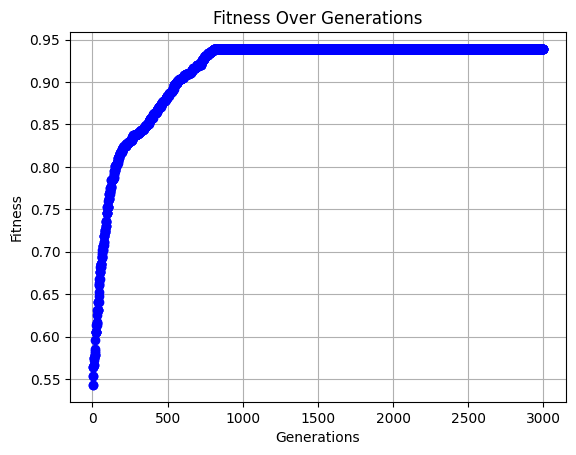

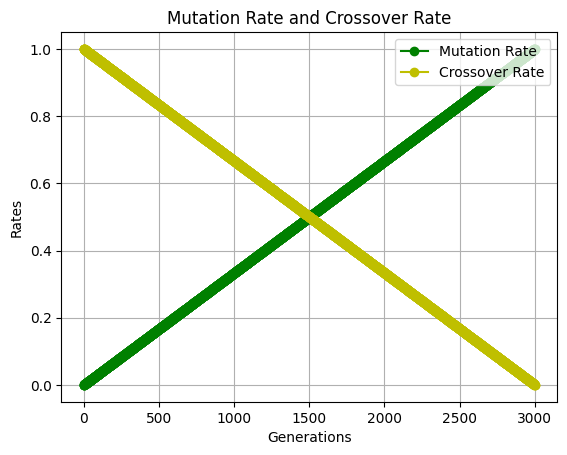

(1+λ):  56%|█████▌    | 1673/3000 [00:19<00:15, 84.60it/s]


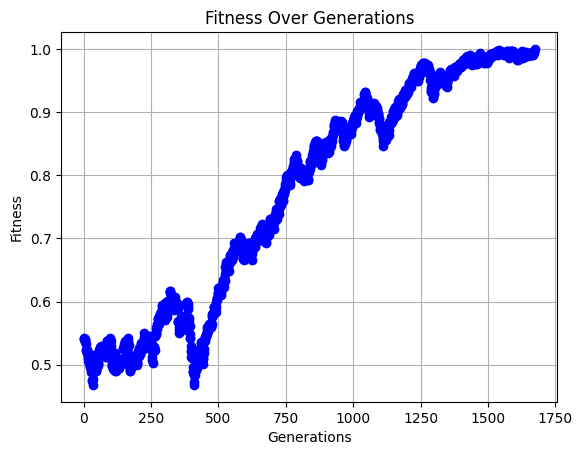

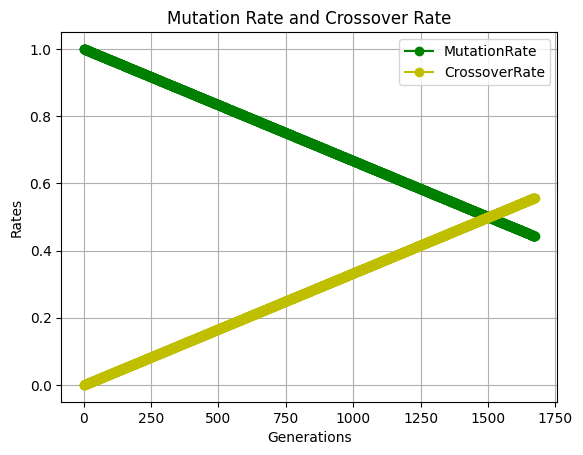

NUMBER OF GENERATION: 3000 FITNESS: 0.939
FITNESS CALL FOR (μ+λ): 60100
NUMBER OF GENERATION: 1673 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 167400
PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FORCE 1


(1+λ):  56%|█████▌    | 1670/3000 [00:06<00:05, 249.53it/s]


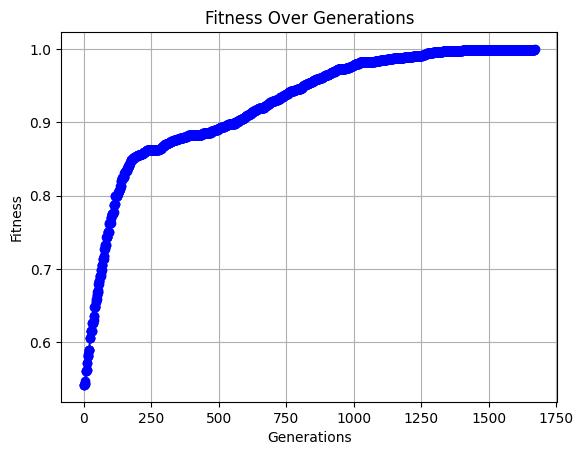

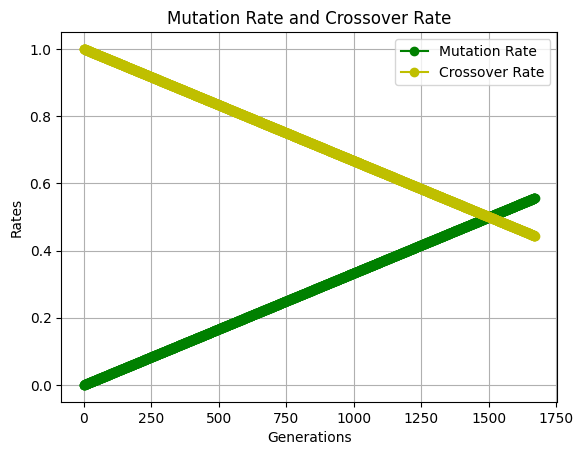

(1+λ):   3%|▎         | 86/3000 [00:00<00:26, 109.12it/s]


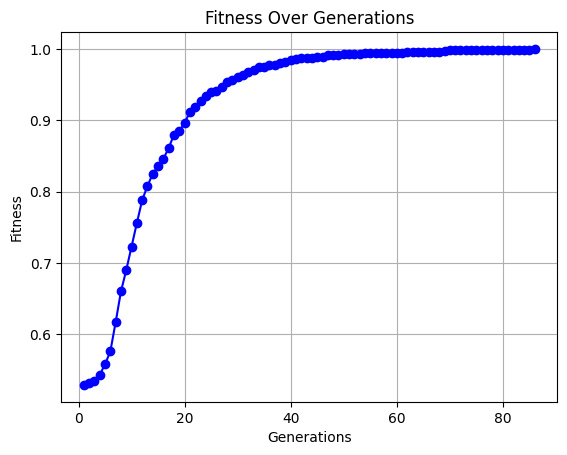

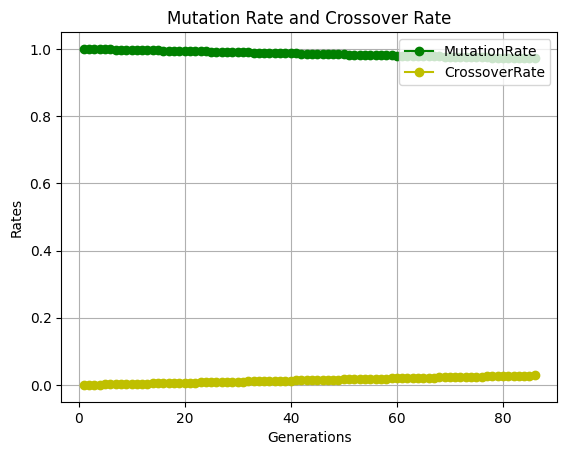

NUMBER OF GENERATION: 1670 FITNESS: 1.0
FITNESS CALL FOR (μ+λ): 33500
NUMBER OF GENERATION: 86 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 8700
PLOTTING GRAPH WITH STATIC RATES WITH MUTATION FLIP


(1+λ): 100%|██████████| 3000/3000 [00:12<00:00, 243.13it/s]


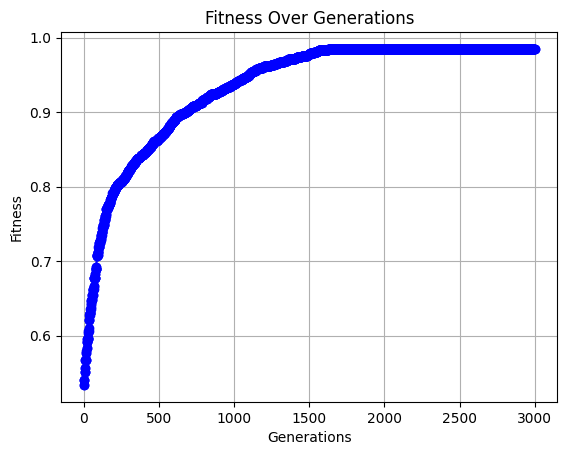

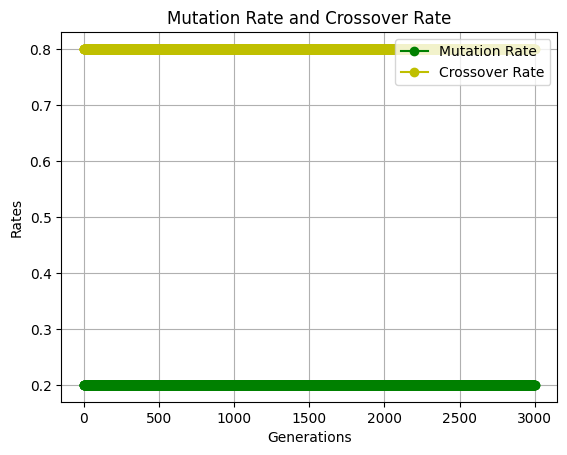

(1+λ):  19%|█▉        | 565/3000 [00:10<00:46, 51.97it/s]


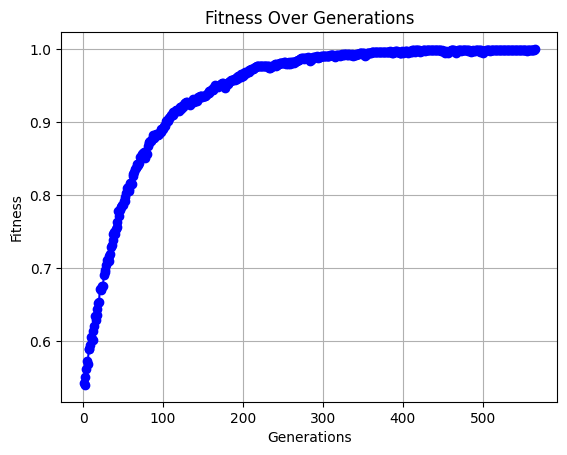

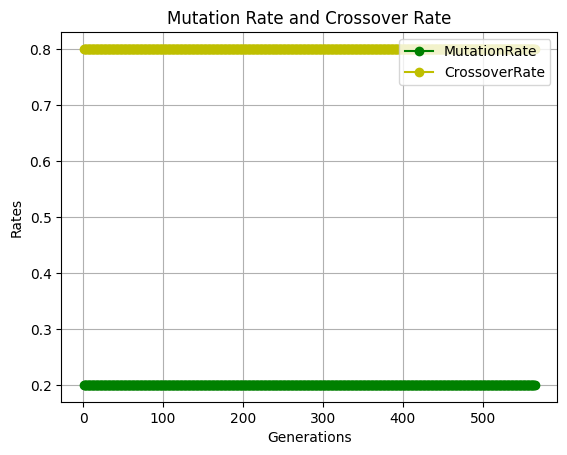

NUMBER OF GENERATION: 3000 FITNESS: 0.985
FITNESS CALL FOR (μ+λ): 60100
NUMBER OF GENERATION: 565 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 56600
PLOTTING GRAPH WITH STATIC RATES WITH MUTATION WITH FORCE 1


(1+λ):  62%|██████▏   | 1864/3000 [00:07<00:04, 262.29it/s]


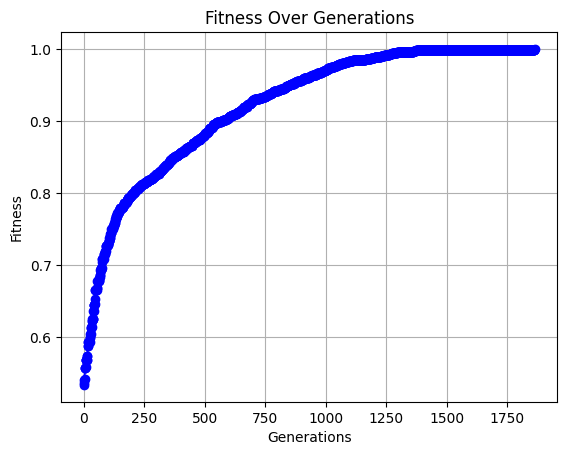

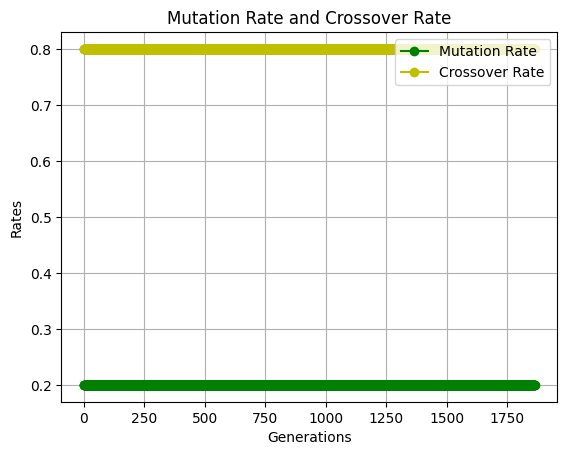

(1+λ):  19%|█▉        | 564/3000 [00:10<00:46, 52.93it/s]


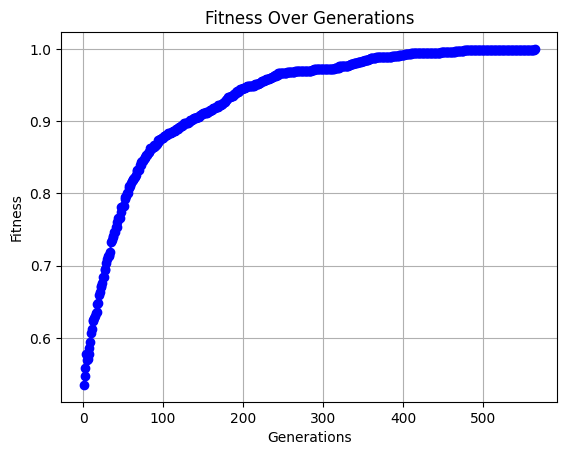

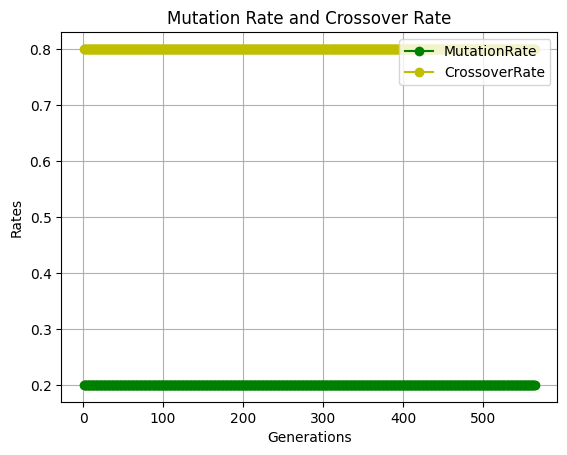

NUMBER OF GENERATION: 1864 FITNESS: 1.0
FITNESS CALL FOR (μ+λ): 37380
NUMBER OF GENERATION: 564 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 56500


In [952]:
print("PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FLIP")
plot_graphs(False,True,"VARIABLE_RATES_MUTATION_FLIP",PROBLEM_SIZE_SMALL, mutateFlip)
print("PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FORCE 1")
plot_graphs(False,True,"VARIABLE_RATES_MUTATION_1",PROBLEM_SIZE_SMALL, mutate) 
print("PLOTTING GRAPH WITH STATIC RATES WITH MUTATION FLIP")
plot_graphs(True,True,"STATIC_RATES_MUTATION_FLIP",PROBLEM_SIZE_SMALL, mutateFlip) 
print("PLOTTING GRAPH WITH STATIC RATES WITH MUTATION WITH FORCE 1")
plot_graphs(True,True,"STATIC_RATES_MUTATION_1",PROBLEM_SIZE_SMALL, mutate) 


# GRAPH PLOT BIG PROBLEM

PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FLIP


(1+λ): 100%|██████████| 3000/3000 [00:12<00:00, 244.28it/s]


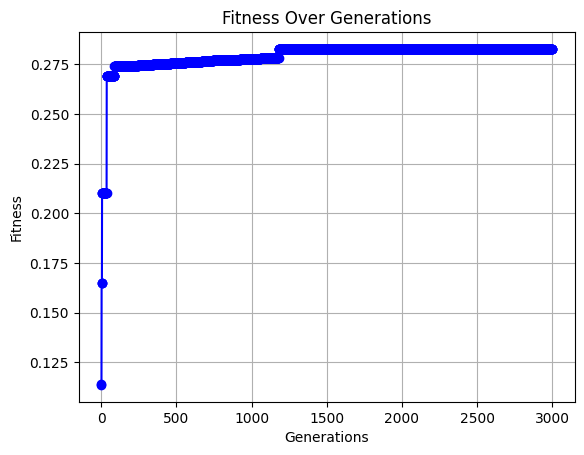

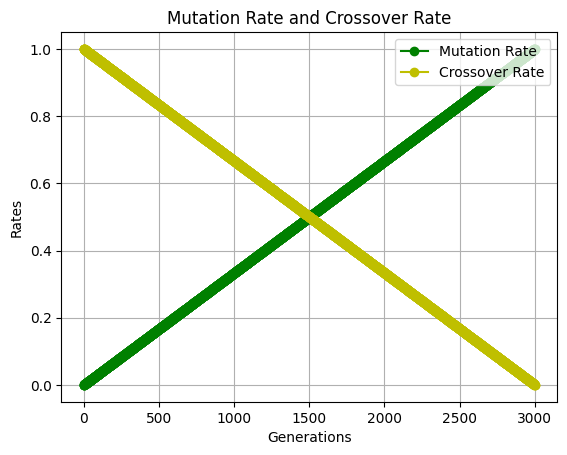

(1+λ):  59%|█████▉    | 1782/3000 [00:22<00:15, 78.26it/s]


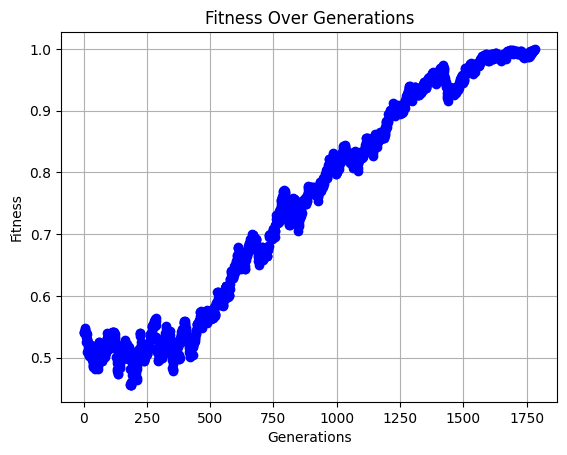

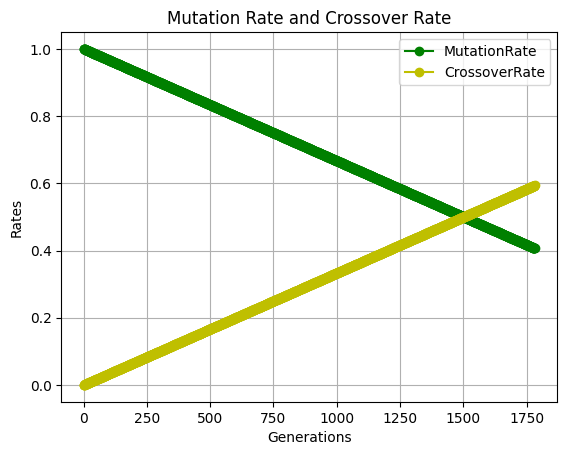

NUMBER OF GENERATION: 3000 FITNESS: 0.28267791
FITNESS CALL FOR (μ+λ): 60100
NUMBER OF GENERATION: 1782 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 178300
PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FORCE 1


(1+λ): 100%|██████████| 3000/3000 [00:09<00:00, 327.48it/s]


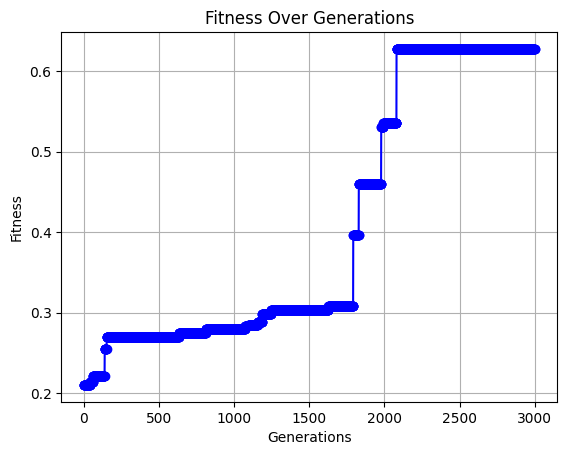

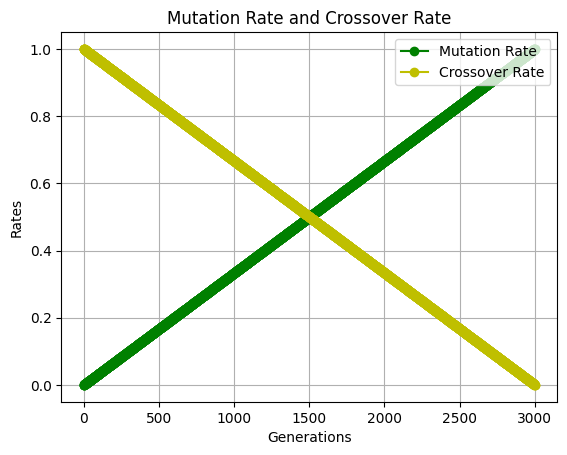

(1+λ):   2%|▏         | 70/3000 [00:00<00:20, 142.57it/s]


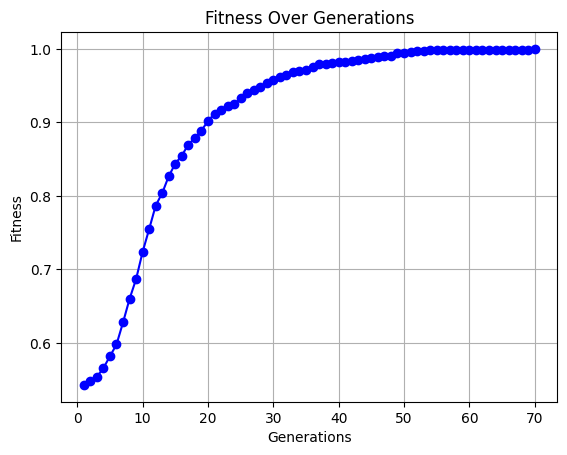

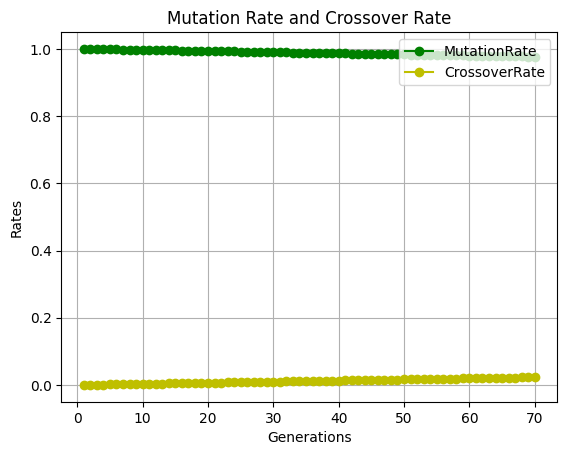

NUMBER OF GENERATION: 3000 FITNESS: 0.627576
FITNESS CALL FOR (μ+λ): 60100
NUMBER OF GENERATION: 70 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 7100
PLOTTING GRAPH WITH STATIC RATES WITH MUTATION FLIP


(1+λ): 100%|██████████| 3000/3000 [00:13<00:00, 219.40it/s]


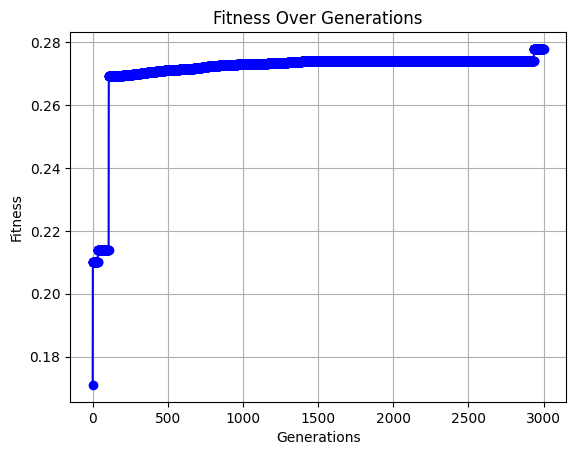

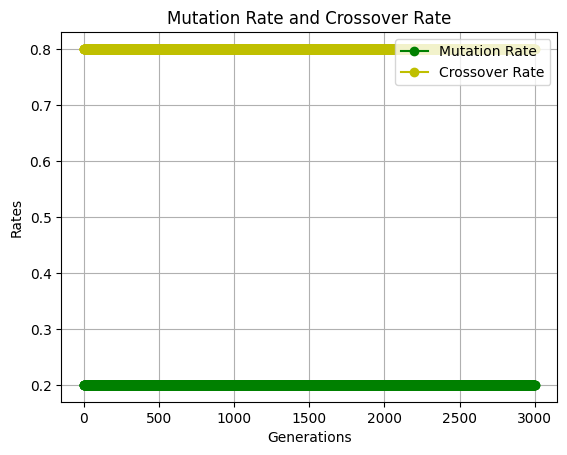

(1+λ):  19%|█▉        | 580/3000 [00:11<00:49, 49.37it/s]


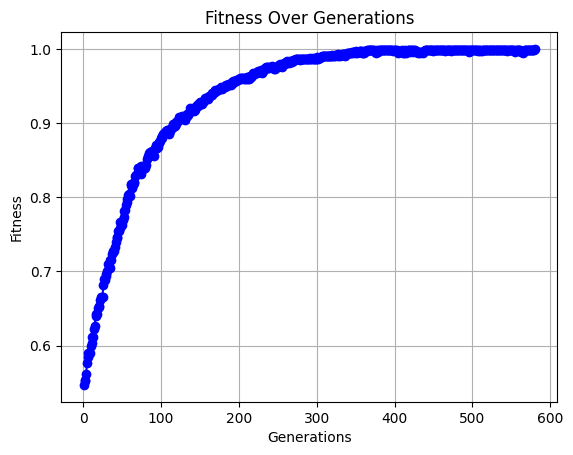

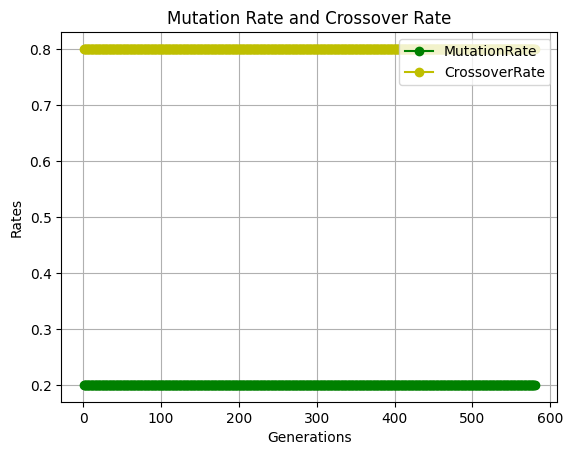

NUMBER OF GENERATION: 3000 FITNESS: 0.27781347
FITNESS CALL FOR (μ+λ): 60100
NUMBER OF GENERATION: 580 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 58100
PLOTTING GRAPH WITH STATIC RATES WITH MUTATION  FORCE 1


(1+λ): 100%|██████████| 3000/3000 [00:13<00:00, 220.15it/s]


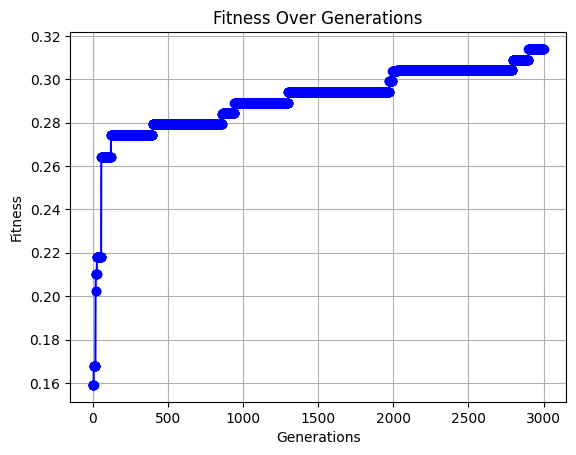

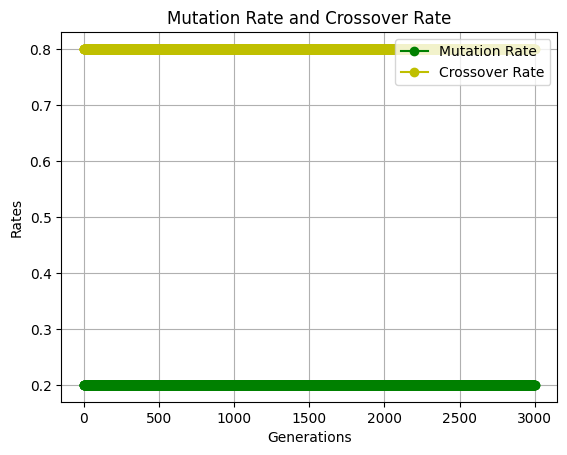

(1+λ):  18%|█▊        | 537/3000 [00:10<00:48, 50.90it/s]


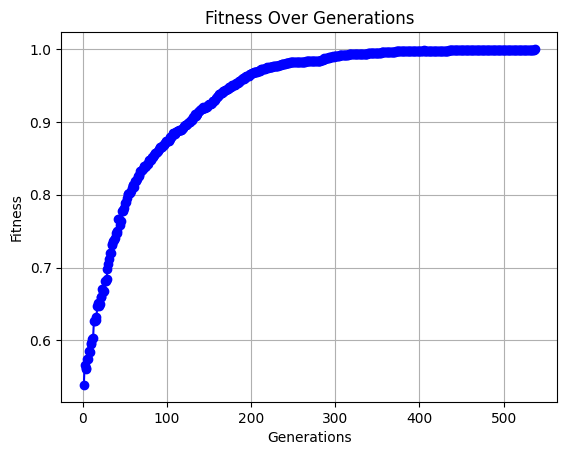

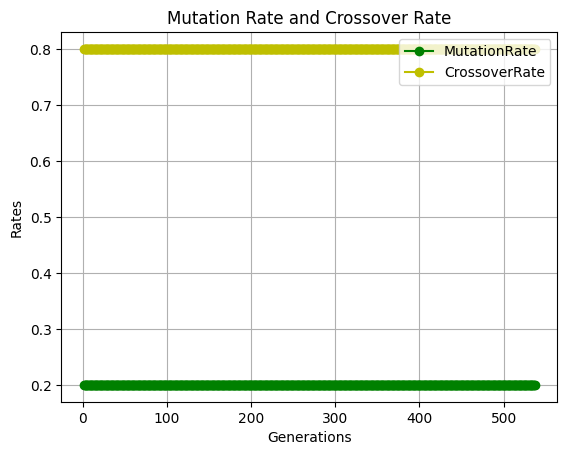

NUMBER OF GENERATION: 3000 FITNESS: 0.31400129
FITNESS CALL FOR (μ+λ): 60100
NUMBER OF GENERATION: 537 FITNESS: 1.0
FITNESS CALL FOR (μ,λ): 53800


In [953]:
print("PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FLIP")
plot_graphs(False,True,"BIG_VARIABLE_RATES_MUTATION_FLIP",PROBLEM_SIZE_BIG, mutateFlip)
print("PLOTTING GRAPH WITH VARIABLE RATES WITH MUTATION FORCE 1")
plot_graphs(False,True,"BIG_VARIABLE_RATES_MUTATION_1",PROBLEM_SIZE_BIG, mutate) 
print("PLOTTING GRAPH WITH STATIC RATES WITH MUTATION FLIP")
plot_graphs(True,True,"BIG_STATIC_RATES_MUTATION_FLIP",PROBLEM_SIZE_BIG, mutateFlip) 
print("PLOTTING GRAPH WITH STATIC RATES WITH MUTATION  FORCE 1")
plot_graphs(True,True,"BIG_ STATIC_RATES_MUTATION_1",PROBLEM_SIZE_BIG, mutate) 